# Insider Trading - Python Tutorial - SEC API

In this tutorial we 
- visualise insider trading of non-derivitate securities per day
- extract SEC filings of type 4 (statement of changes in beneficial ownership of securities, aka insider trades) 
- use the [SEC API](https://sec-api.io) to access SEC filings 

I explain more details about SEC Form 4 in [my Medium article here](https://medium.com/@jan_5421/insider-trading-visualised-with-python-sec-api-io-5f12a7799b3e)

You can find a detailed documentation of SEC API here: https://sec-api.io/docs 

## Boilterplate

Let's start by defining some boilerplate to fetch filings and format the returned values.

Get your API key on [sec-api.io](https://sec-api.io) and replace `YOUR_API_KEY` in the code below with it.

In [1]:
# Package used to execute HTTP POST request to the API
import json
import urllib.request

# API KeyTOKEN = YOUR_API_KEY # replace YOUR_API_KEY with the key you got from sec-api.io
# API endpoint
API = "https://api.sec-api.io"

# Define the filter parameters
filter = "formType:\"4\" AND formType:(NOT \"N-4\") AND formType:(NOT \"4/A\") AND filedAt:[2019-07-01 TO 2019-08-01]"
# Start with the first filing. Increase it when paginating. 
# Set to 10000 if you want to fetch the next batch of filings. Set to 20000 for the next and so on.
start = 0
# Return 10,000 filings per API call
size = 10000
# Sort in descending order by filedAt
sort = [{ "filedAt": { "order": "desc" } }]

payload = {
  "query": { "query_string": { "query": filter } },
  "from": start,
  "size": size,
  "sort": sort
}

# Format your payload to JSON bytes
jsondata = json.dumps(payload)
jsondataasbytes = jsondata.encode('utf-8')   # needs to be bytes

# Instantiate the request 
req = urllib.request.Request(API)

# Set the correct HTTP header: Content-Type = application/json
req.add_header('Content-Type', 'application/json; charset=utf-8')
# Set the correct length of your request
req.add_header('Content-Length', len(jsondataasbytes))

# Send the request to the API
response = urllib.request.urlopen(req, jsondataasbytes)

# Read the response 
res_body = response.read()
# Transform the response into JSON
filingsJson = json.loads(res_body.decode("utf-8"))

## Inspect filings

In [2]:
# Print the response. Most likely this will throw an error because we fetched a
# large amount of data (10,000 filings). Reduce the number of filings and you will see a result here.
print(json.dumps(filingsJson, indent=2))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [3]:
# Show us how many filings matched our filter criteria. 
# This number is most likely different from the number of filings returned by the API.
print(filingsJson['total'])

21521


## Compressing Filings (for demo purposes only)

We reduce the number of filings per day to a maximum of 5 for demo purposes so that you can run this notebook on your local machine. You can run it without reducing the size, but it takes significantly longer because each SEC filing is downloaded in series.  

Feel free to add a parallel downloader to accelerate the process.

In [4]:
def compress_filings (filings):
    store = {}
    compressed_filings = []
    for filing in filings:
        filedAt = filing['filedAt']
        if filedAt in store and store[filedAt] < 5:
            compressed_filings.append(filing)
            store[filedAt] += 1
        elif filedAt not in store:
            compressed_filings.append(filing)
            store[filedAt] = 1
    return compressed_filings

In [5]:
filings = compress_filings(filingsJson['filings'])
filings

[{'cik': '940944',
  'companyName': 'DARDEN RESTAURANTS INC',
  'filedAt': '2019-08-01',
  'formType': '4',
  'id': '9e56073b1a40b7a1c9d5e9eed3b6c7bd',
  'linkToHtml': 'https://www.sec.gov/Archives/edgar/data/940944/0001225208-19-010784-index.htm',
  'linkToTxt': 'https://www.sec.gov/Archives/edgar/data/940944/0001225208-19-010784.txt',
  'ticker': 'DRI'},
 {'cik': '940944',
  'companyName': 'DARDEN RESTAURANTS INC',
  'filedAt': '2019-08-01',
  'formType': '4',
  'id': 'e32dcb14f23fcab978203d38457ef61a',
  'linkToHtml': 'https://www.sec.gov/Archives/edgar/data/940944/0001225208-19-010788-index.htm',
  'linkToTxt': 'https://www.sec.gov/Archives/edgar/data/940944/0001225208-19-010788.txt',
  'ticker': 'DRI'},
 {'cik': '940944',
  'companyName': 'DARDEN RESTAURANTS INC',
  'filedAt': '2019-08-01',
  'formType': '4',
  'id': 'e4849f9d85d6e03927f979aba07f8e5e',
  'linkToHtml': 'https://www.sec.gov/Archives/edgar/data/940944/0001225208-19-010792-index.htm',
  'linkToTxt': 'https://www.sec.g

# Download Filing 4 Data

Let's implement the download and XML parse methods. The XML parser extracts all non-derivitative transactions listed in the 4 filing. It considers `disposal` and `acquisition` of items and calculates the sum of all transactions (sold and bought).

**Important:** the downloader doesn't differentiate between filing issuer and reporter. In other words, we download the issuer's and reporter's filing. The reported transactions in both filings are the same and we double count transactions. That's OK for demonstration purposes but has to be cleaned when building a production version.

In [6]:
import xml.etree.ElementTree as ET
import re
import time

# Download the XML version of the filing. If it fails wait for 5, 10, 15, ... seconds and try again.
def download_xml (url, tries = 1):
    try: 
        response = urllib.request.urlopen(url)
    except:
        print('Something went wrong. Wait for 5 seconds and try again.', tries)
        if tries < 5:
            time.sleep(5 * tries)
            download_xml(url, tries + 1)
    else:     
        # decode the response into a string
        data = response.read().decode('utf-8')
        # set up the regular expression extractoer in order to get the relevant part of the filing
        matcher = re.compile('<\?xml.*ownershipDocument>', flags=re.MULTILINE|re.DOTALL)
        matches = matcher.search(data)
        # the first matching group is the extracted XML of interest
        xml = matches.group(0)
        # instantiate the XML object
        root = ET.fromstring(xml)
        print(url)
        return root 

In [7]:
# Calculate the total transaction amount in $ of a giving form 4 in XML
def calculate_transaction_amount (xml):
    total = 0
    
    if xml is None:
        return total
    
    nonDerivativeTransactions = xml.findall("./nonDerivativeTable/nonDerivativeTransaction")

    for t in nonDerivativeTransactions:
        # D for disposed or A for acquired
        action = t.find('./transactionAmounts/transactionAcquiredDisposedCode/value').text
        # number of shares disposed/acquired
        shares = t.find('./transactionAmounts/transactionShares/value').text
        # price
        priceRaw = t.find('./transactionAmounts/transactionPricePerShare/value')
        price = 0 if priceRaw is None else priceRaw.text
        # set prefix to -1 if derivatives were disposed. set prefix to 1 if derivates were acquired.
        prefix = -1 if action == 'D' else 1
        # calculate transaction amount in $
        amount = prefix * float(shares) * float(price)
        total += amount
    
    return round(total, 2)

In [8]:
# Test the calc function by using just one filing  
url = 'https://www.sec.gov/Archives/edgar/data/1592176/0000706688-19-000155.txt'    
xml = download_xml(url) 
amount = calculate_transaction_amount(xml)
amount

https://www.sec.gov/Archives/edgar/data/1592176/0000706688-19-000155.txt


-77996.0

In [9]:
# Download the XML for each filing
# Calculate the total transaction amount per filing
# Save the calculate transaction value to the filing dict with key 'nonDerivativeTransactions' 
def add_non_derivative_transaction_amounts ():
    for filing in filings:
        url = filing['linkToTxt']
        xml = download_xml(url)
        nonDerivativeTransactions = calculate_transaction_amount(xml)
        filing['nonDerivativeTransactions'] = nonDerivativeTransactions

In [10]:
# Running the function prints the URL of each filing fetched
add_non_derivative_transaction_amounts()

https://www.sec.gov/Archives/edgar/data/940944/0001225208-19-010784.txt
https://www.sec.gov/Archives/edgar/data/940944/0001225208-19-010788.txt
https://www.sec.gov/Archives/edgar/data/940944/0001225208-19-010792.txt
https://www.sec.gov/Archives/edgar/data/945841/0000945841-19-000119.txt
https://www.sec.gov/Archives/edgar/data/91440/0001127602-19-025675.txt
https://www.sec.gov/Archives/edgar/data/943819/0001127602-19-025470.txt
https://www.sec.gov/Archives/edgar/data/937098/0000937098-19-000186.txt
https://www.sec.gov/Archives/edgar/data/97745/0001127602-19-025508.txt
https://www.sec.gov/Archives/edgar/data/1592176/0000706688-19-000155.txt
https://www.sec.gov/Archives/edgar/data/913144/0001209191-19-043844.txt
https://www.sec.gov/Archives/edgar/data/940944/0001225208-19-010705.txt
https://www.sec.gov/Archives/edgar/data/940944/0001225208-19-010702.txt
https://www.sec.gov/Archives/edgar/data/914208/0001209191-19-043653.txt
https://www.sec.gov/Archives/edgar/data/912767/0001214659-19-0048

In [11]:
# Let's inspect filings and ensure that the new key 'nonDerivativeTransactions' is set
filings

[{'cik': '940944',
  'companyName': 'DARDEN RESTAURANTS INC',
  'filedAt': '2019-08-01',
  'formType': '4',
  'id': '9e56073b1a40b7a1c9d5e9eed3b6c7bd',
  'linkToHtml': 'https://www.sec.gov/Archives/edgar/data/940944/0001225208-19-010784-index.htm',
  'linkToTxt': 'https://www.sec.gov/Archives/edgar/data/940944/0001225208-19-010784.txt',
  'nonDerivativeTransactions': -14359.44,
  'ticker': 'DRI'},
 {'cik': '940944',
  'companyName': 'DARDEN RESTAURANTS INC',
  'filedAt': '2019-08-01',
  'formType': '4',
  'id': 'e32dcb14f23fcab978203d38457ef61a',
  'linkToHtml': 'https://www.sec.gov/Archives/edgar/data/940944/0001225208-19-010788-index.htm',
  'linkToTxt': 'https://www.sec.gov/Archives/edgar/data/940944/0001225208-19-010788.txt',
  'nonDerivativeTransactions': -32749.6,
  'ticker': 'DRI'},
 {'cik': '940944',
  'companyName': 'DARDEN RESTAURANTS INC',
  'filedAt': '2019-08-01',
  'formType': '4',
  'id': 'e4849f9d85d6e03927f979aba07f8e5e',
  'linkToHtml': 'https://www.sec.gov/Archives/e

# Preperation for plotting

We transform `filings` into a pandas dataframe with the following columns:
- filedAt
- type
- CIK
- ticker
- companyName
- linkToTxt
- linkToHtml
- nonDerivativeTransactions (previously added)


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pandas.io.json import json_normalize

In [13]:
filings = json_normalize(filings)
filings

,cik,ticker,companyName,formType,filedAt,linkToTxt,linkToHtml,id,nonDerivativeTransactions
0,940944,DRI,DARDEN RESTAURANTS INC,4,2019-08-01,https://www.sec.gov/Archives/edgar/data/940944...,https://www.sec.gov/Archives/edgar/data/940944...,9e56073b1a40b7a1c9d5e9eed3b6c7bd,-1.435944e+04
1,940944,DRI,DARDEN RESTAURANTS INC,4,2019-08-01,https://www.sec.gov/Archives/edgar/data/940944...,https://www.sec.gov/Archives/edgar/data/940944...,e32dcb14f23fcab978203d38457ef61a,-3.274960e+04
2,940944,DRI,DARDEN RESTAURANTS INC,4,2019-08-01,https://www.sec.gov/Archives/edgar/data/940944...,https://www.sec.gov/Archives/edgar/data/940944...,e4849f9d85d6e03927f979aba07f8e5e,-6.046080e+03
3,945841,POOL,POOL CORP,4,2019-08-01,https://www.sec.gov/Archives/edgar/data/945841...,https://www.sec.gov/Archives/edgar/data/945841...,8bcdc14c786ac69b5e55d91fbd5973c7,-5.911782e+05
4,91440,SNA,SNAP-ON Inc,4,2019-08-01,https://www.sec.gov/Archives/edgar/data/91440/...,https://www.sec.gov/Archives/edgar/data/91440/...,4e1b26768f4a93a5a5fc87101daca657,1.236141e+04
5,943819,RMD,RESMED INC,4,2019-07-31,https://www.sec.gov/Archives/edgar/data/943819...,https://www.sec.gov/Archives/edgar/data/943819...,35ba19b15daa1028409d1c45fd29c4c1,-1.563563e+06
6,937098,TNET,TRINET GROUP INC,4,2019-07-31,https://www.sec.gov/Archives/edgar/data/937098...,https://www.sec.gov/Archives/edgar/data/937098...,c34cd75a3efe2b24e8c709d5204ecbae,-4.478306e+05
7,97745,TMO,THERMO FISHER SCIENTIFIC INC.,4,2019-07-31,https://www.sec.gov/Archives/edgar/data/97745/...,https://www.sec.gov/Archives/edgar/data/97745/...,a6c643d9fb6e920ea24c6ba2b96fdcbe,-1.057937e+07
8,1592176,,Kamerschen Robert W.,4,2019-07-31,https://www.sec.gov/Archives/edgar/data/159217...,https://www.sec.gov/Archives/edgar/data/159217...,b1d46fc21be8a3442a918c098c057d94,-7.799600e+04
9,913144,RNR,RENAISSANCERE HOLDINGS LTD,4,2019-07-31,https://www.sec.gov/Archives/edgar/data/913144...,https://www.sec.gov/Archives/edgar/data/913144...,f410770c9a0f428a5fe5136c5ba42d70,-1.712227e+05


# Bucketize

For each day we summarize all transactions and create a new dictionary `bins`.

In [14]:
def getBins (filings):
    bins = {}
    for index, row in filings.iterrows():
        filedAt = row['filedAt']
        nonDerivativeTransactions = row['nonDerivativeTransactions']
        value = bins[filedAt] + nonDerivativeTransactions if filedAt in bins else nonDerivativeTransactions
        bins[filedAt] = round(value, 2)
    return bins

In [15]:
bins = getBins(filings)
bins

{'2019-07-12': -905404.34,
 '2019-07-15': -64796.91,
 '2019-07-16': 216185185.2,
 '2019-07-17': -1911878.89,
 '2019-07-18': 9439306.72,
 '2019-07-19': 141703.94,
 '2019-07-22': -513300.02,
 '2019-07-23': -2178988.85,
 '2019-07-24': -574940.5,
 '2019-07-25': 32031.12,
 '2019-07-26': -1537916.47,
 '2019-07-29': -44878201.64,
 '2019-07-30': -1826422.32,
 '2019-07-31': -12839978.42,
 '2019-08-01': -631971.96}

# Plotting

We plot a bar chart where each bar represents the total transactions per day.

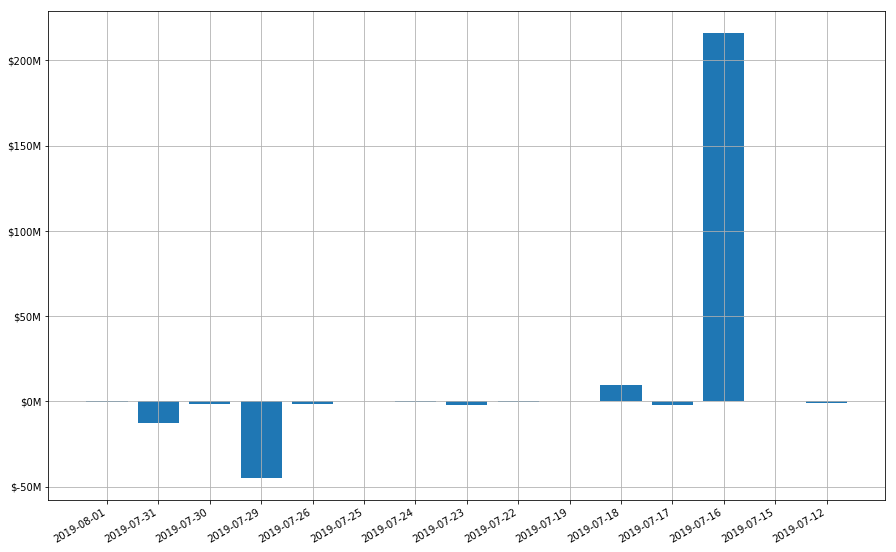

In [16]:
# Set size of figure
plt.rcParams['figure.figsize'] = [15, 10]

# Prettify y axis: 2000000 to $2M
def millions(x, pos):
    return '${:,.0f}M'.format(x*1e-6)

fig, ax = plt.subplots()
# Define bar plot
ax.bar(range(len(bins)), list(bins.values()), align='center')
ax.grid(True)
ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions))
# Prettify x axis
fig.autofmt_xdate()
# Set x axis values
plt.xticks(range(len(bins)), list(bins.keys()))
plt.show()